In [1]:
import pandas as pd
import seaborn as sns
import warnings  # To suppress some warnings
import matplotlib.pyplot as plt
import numpy as np

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


sns.set_style("whitegrid")
plt.rcParams["figure.constrained_layout.use"] = True

In [2]:
df = pd.read_csv("../data/raw/train.csv")
df = df.drop(columns=["id"])
df = df.sample(frac=0.2)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 615097 to 549833
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Age                   236227 non-null  float64
 1   Gender                240000 non-null  object 
 2   Annual Income         231013 non-null  float64
 3   Marital Status        236286 non-null  object 
 4   Number of Dependents  218035 non-null  float64
 5   Education Level       240000 non-null  object 
 6   Occupation            168264 non-null  object 
 7   Health Score          225188 non-null  float64
 8   Location              240000 non-null  object 
 9   Policy Type           240000 non-null  object 
 10  Previous Claims       167270 non-null  float64
 11  Vehicle Age           239998 non-null  float64
 12  Credit Score          212511 non-null  float64
 13  Insurance Duration    239999 non-null  float64
 14  Policy Start Date     240000 non-null  object 
 15  

## Columns with NaNs

Quite a few columns contain NaNs data. In particular "Occupation", "Previous Clains" and "Credit Score" which can be a bit challenging to impute. We will see if they are correlated to the target.

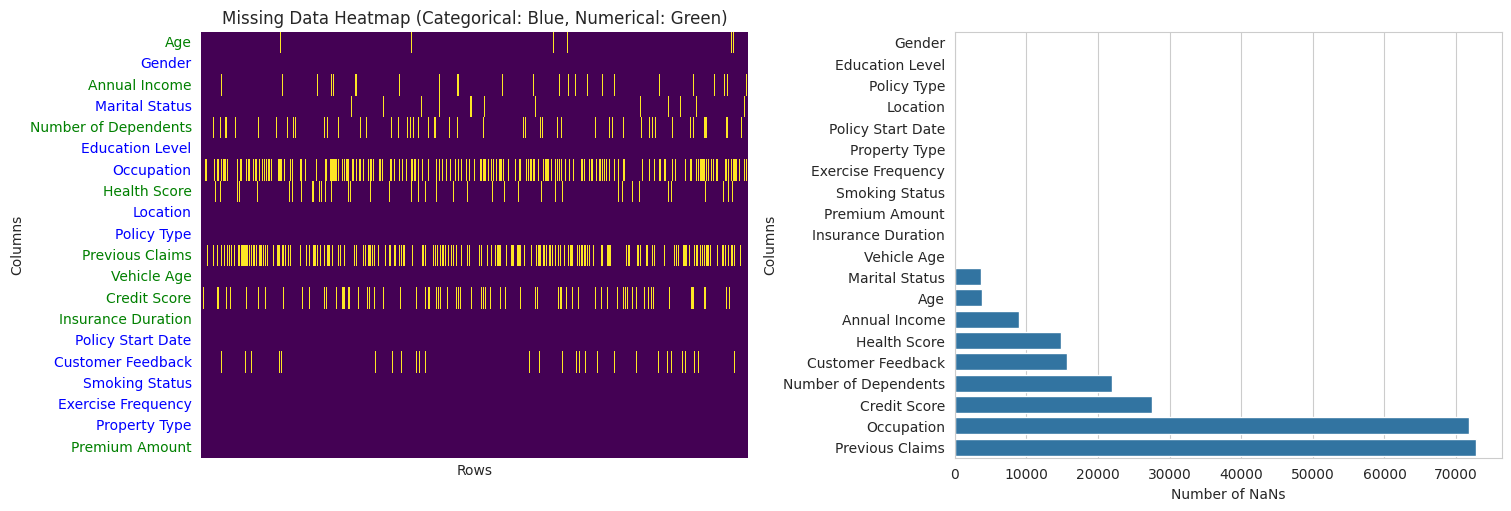

In [3]:
# Determine column types
categorical_columns = df.select_dtypes(include=["object", "category"]).columns
numerical_columns = df.select_dtypes(include=["number"]).columns
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(df.isnull().T, cbar=False, cmap="viridis", xticklabels=False, ax=ax1)
# Color the y-axis labels
for label in ax1.get_yticklabels():
    if label.get_text() in categorical_columns:
        label.set_color("blue")
    elif label.get_text() in numerical_columns:
        label.set_color("green")

# Set labels and title
ax1.set_title("Missing Data Heatmap (Categorical: Blue, Numerical: Green)")
ax1.set_ylabel("Columns")
ax1.set_xlabel("Rows")


sns.barplot(df.isnull().sum().sort_values(), orient="y", ax=ax2)
ax2.set_ylabel("Columns")
ax2.set_xlabel("Number of NaNs")

plt.show()

## Categorical data

Categorical are quite uniformly distributed. **There is no categorical columns with high cardinality.**

"Policy Start Date" should not have been classified as categorical in the plot above. We should convert it to ordinal but this is not an issue.

<Axes: xlabel='Occupation', ylabel='count'>

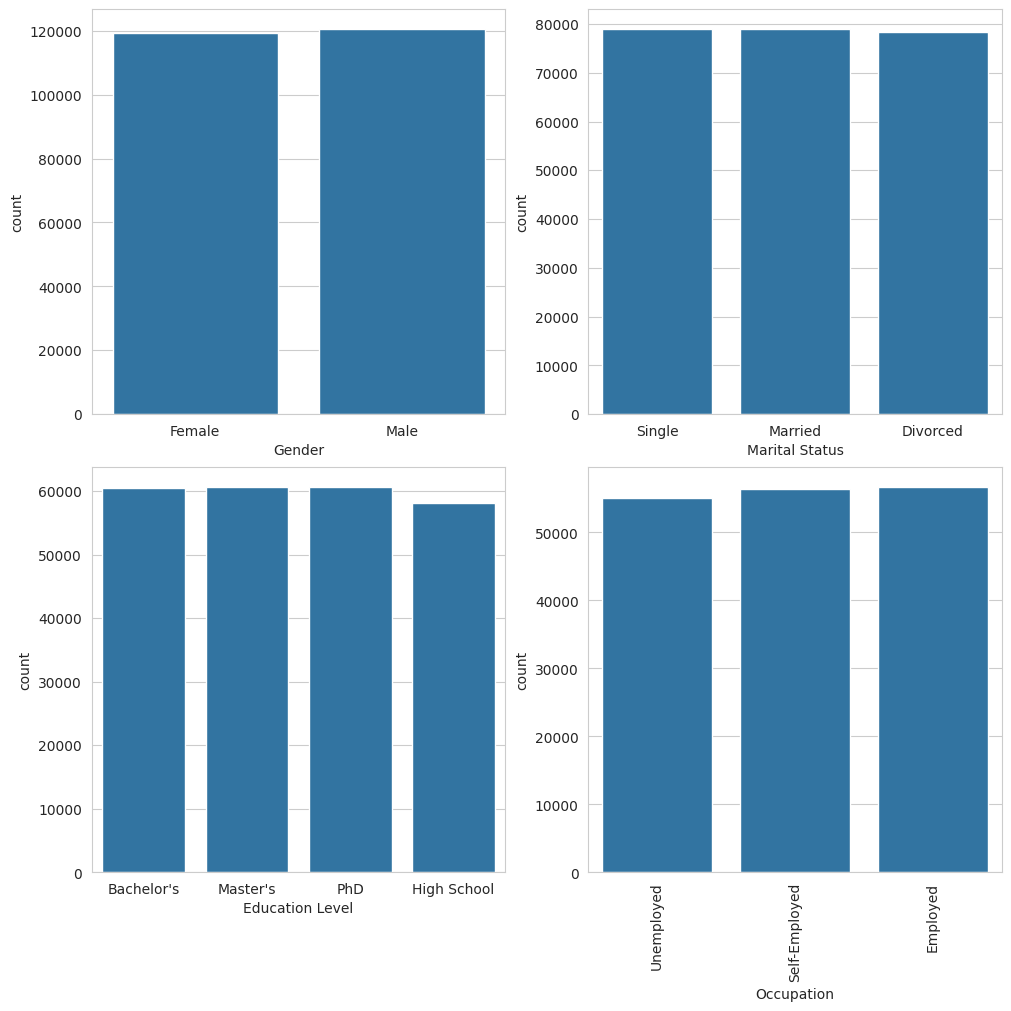

In [4]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))

plt.xticks(rotation=90)
sns.countplot(df, x="Gender", ax=ax1)
sns.countplot(df, x="Marital Status", ax=ax2)
sns.countplot(df, x="Education Level", ax=ax3)
sns.countplot(df, x="Occupation", ax=ax4)

<Axes: xlabel='Smoking Status', ylabel='count'>

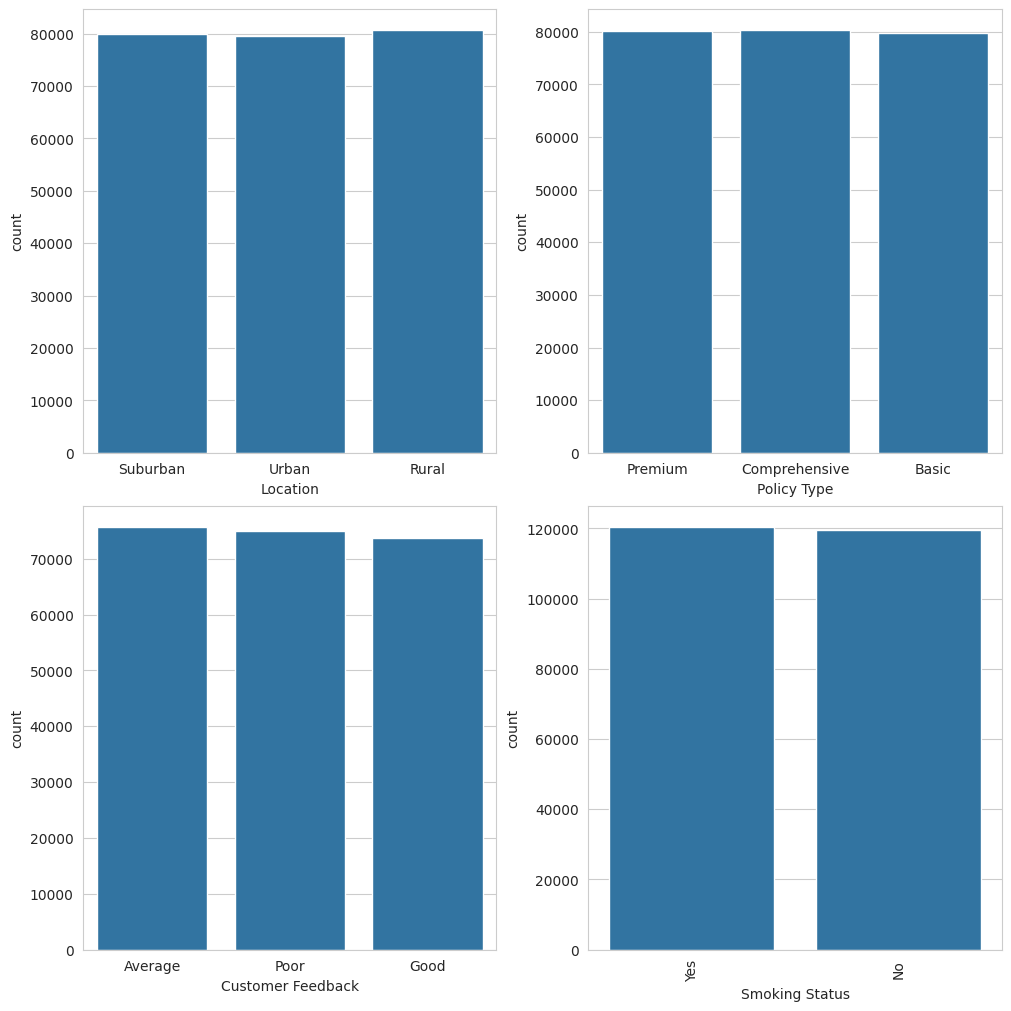

In [5]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))

plt.xticks(rotation=90)
sns.countplot(df, x="Location", ax=ax1)
sns.countplot(df, x="Policy Type", ax=ax2)
sns.countplot(df, x="Customer Feedback", ax=ax3)
sns.countplot(df, x="Smoking Status", ax=ax4)

<Axes: xlabel='Property Type', ylabel='count'>

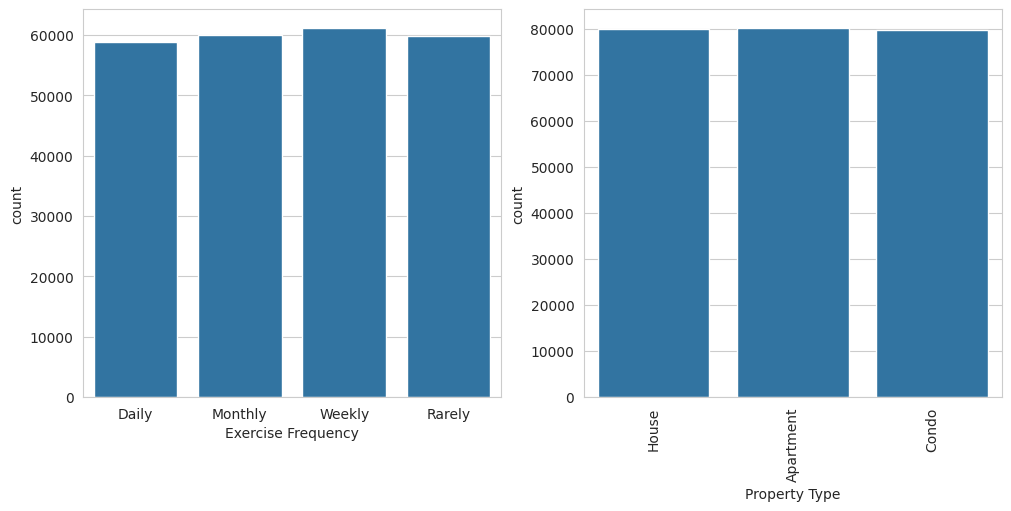

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))

plt.xticks(rotation=90)
sns.countplot(df, x="Exercise Frequency", ax=ax1)
sns.countplot(df, x="Property Type", ax=ax2)

## Numerical data

The most relevant columns appear to be Annual Income, Credit Score, and Previous Claims, as they exhibit the highest correlation with the target variable, Premium Amount.

Previous Claims shows a positive correlation with Premium Amount, which aligns with expectations since insurance companies typically charge higher premiums for "risky" clients who are more likely to file claims. Notably, this feature has the strongest correlation with the target, making it crucial to identify a robust method for imputing any missing values.

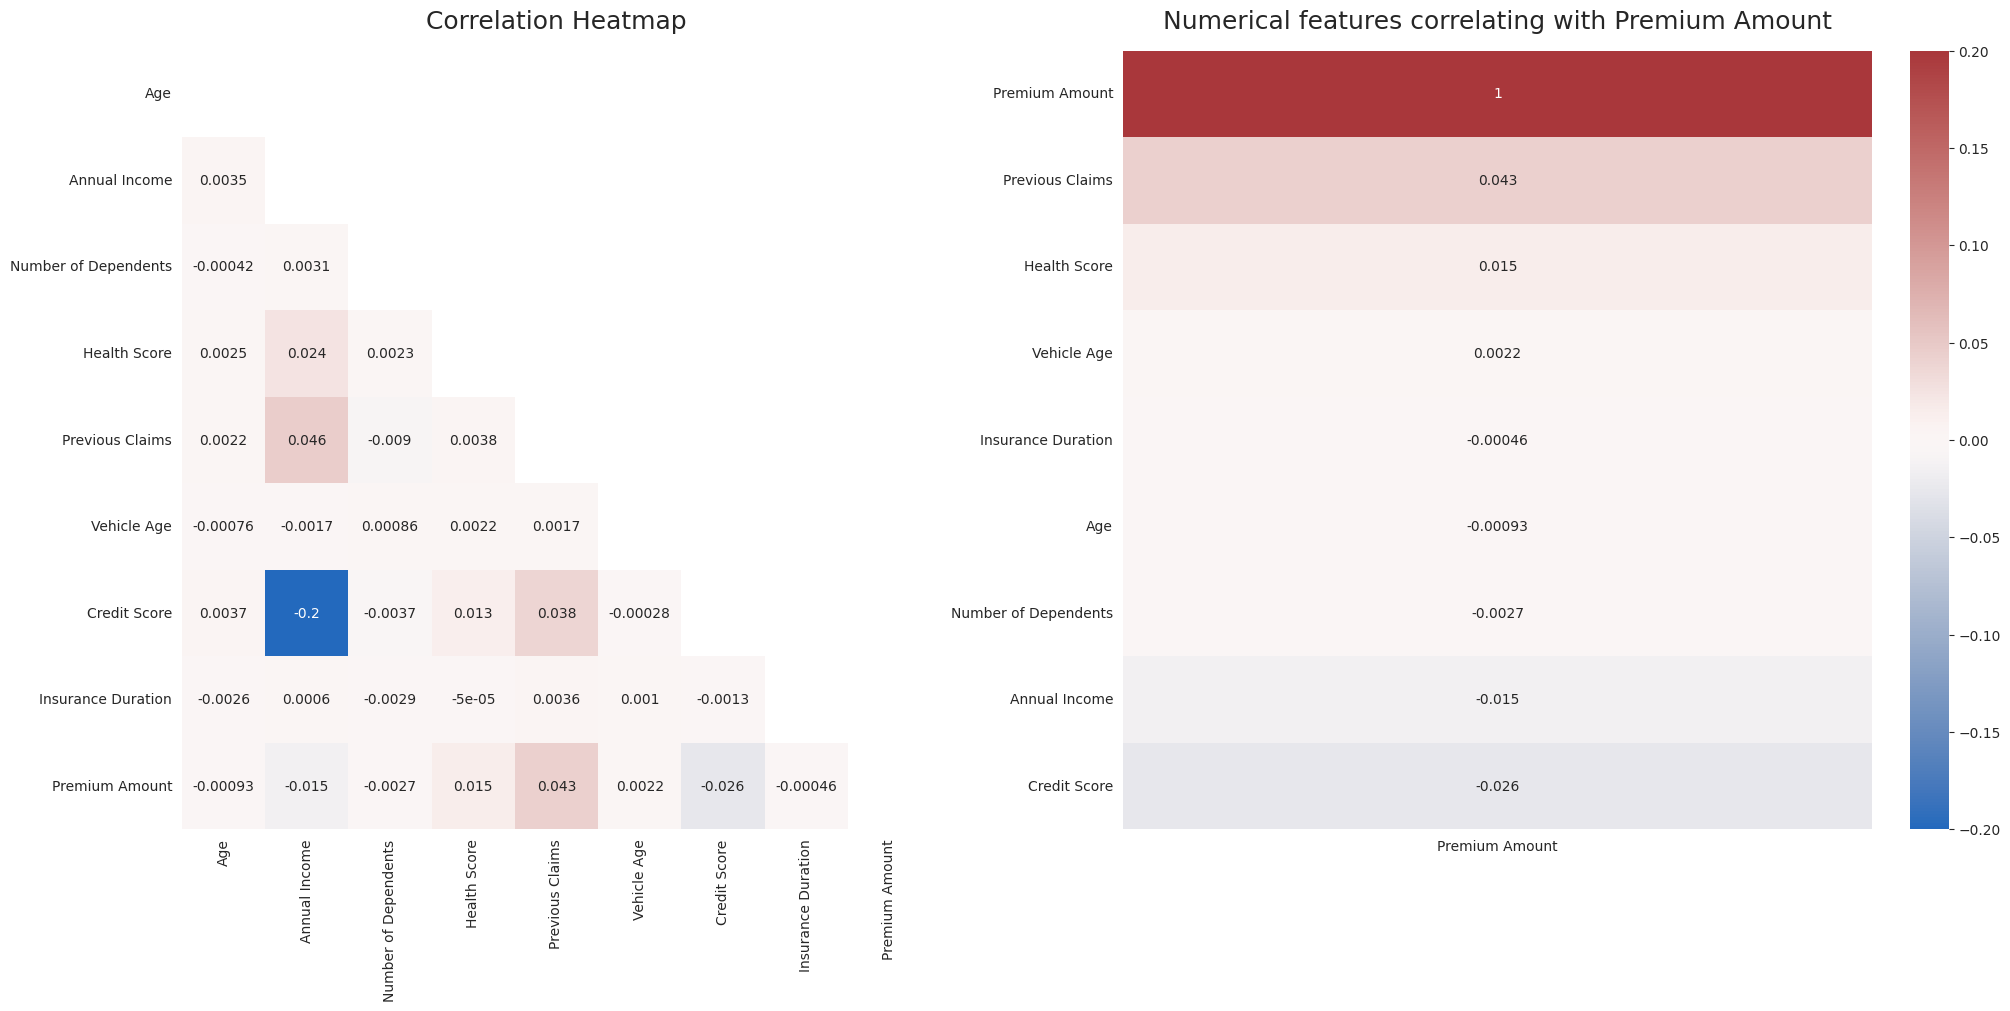

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap="vlag", annot=True, vmin=-0.2, vmax=0.2, cbar=None, ax=ax1)
ax1.grid(False)
ax1.set_title("Correlation Heatmap", fontdict={"fontsize": 18}, pad=16)

sns.heatmap(
    corr[["Premium Amount"]].sort_values(by="Premium Amount", ascending=False),
    vmin=-0.2,
    vmax=0.2,
    annot=True,
    cmap="vlag",
    ax=ax2,
)
ax2.set_title(
    "Numerical features correlating with Premium Amount", fontdict={"fontsize": 18}, pad=16
)
plt.show()

### Distributions

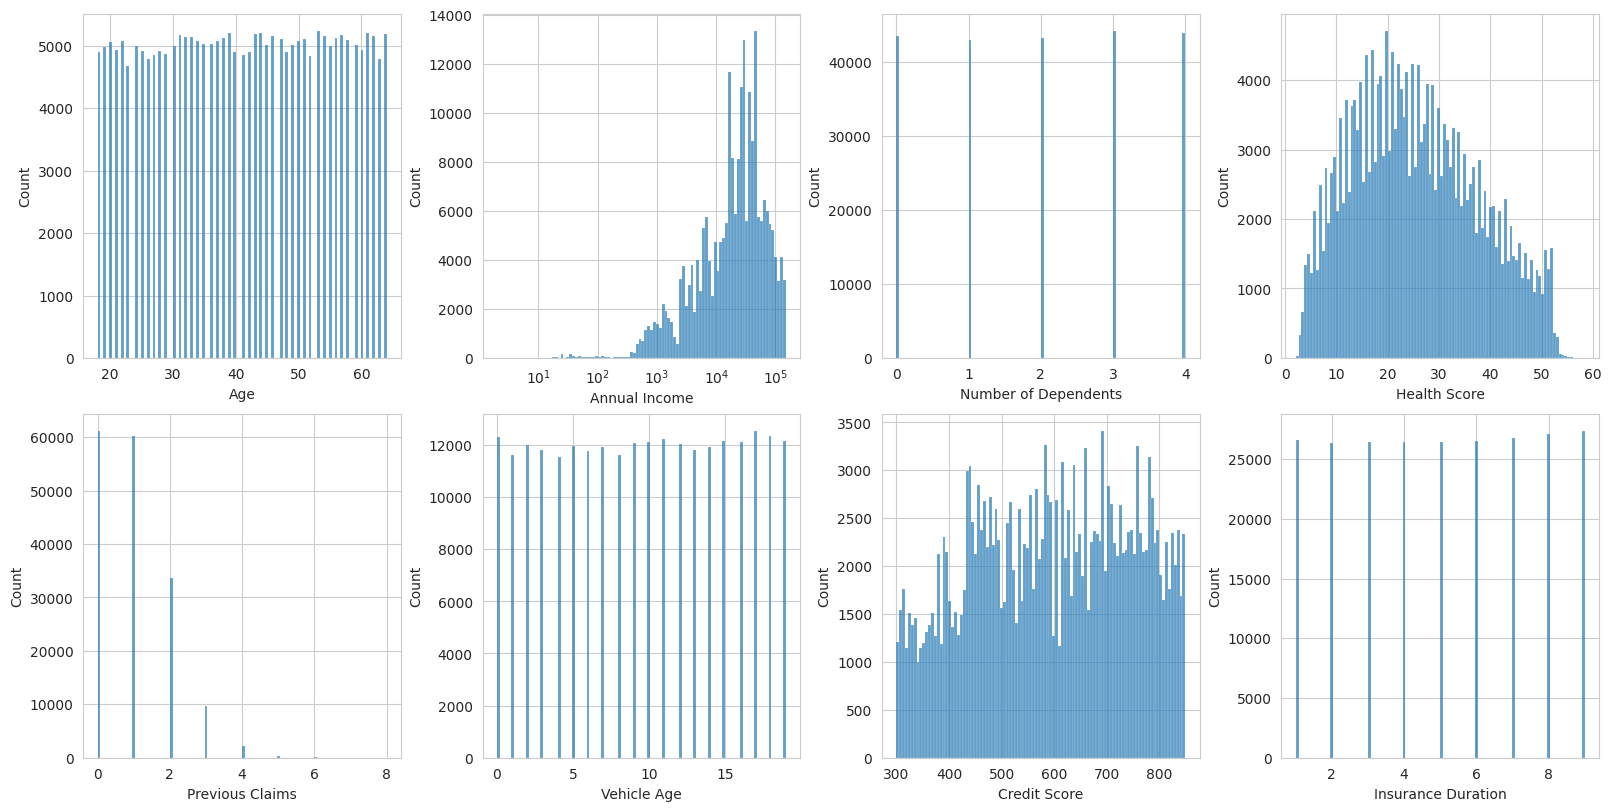

In [8]:
fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(16, 8))
sns.histplot(data=df, x="Age", bins=100, alpha=0.7, lw=0.1, ax=ax1)
sns.histplot(data=df, x="Annual Income", bins=100, alpha=0.7, lw=0.1, ax=ax2, log_scale=True)
sns.histplot(data=df, x="Number of Dependents", bins=100, alpha=0.7, lw=0.1, ax=ax3)
sns.histplot(data=df, x="Health Score", bins=100, alpha=0.7, lw=0.1, ax=ax4)
sns.histplot(data=df, x="Previous Claims", bins=100, alpha=0.7, lw=0.1, ax=ax5)
sns.histplot(data=df, x="Vehicle Age", bins=100, alpha=0.7, lw=0.1, ax=ax6)
sns.histplot(data=df, x="Credit Score", bins=100, alpha=0.7, lw=0.1, ax=ax7)
sns.histplot(data=df, x="Insurance Duration", bins=100, alpha=0.7, lw=0.1, ax=ax8)
plt.show()

## Target

The target distribution cover three orders of magnitude. Our model should be trained on predicted the log of the Premium Amount.

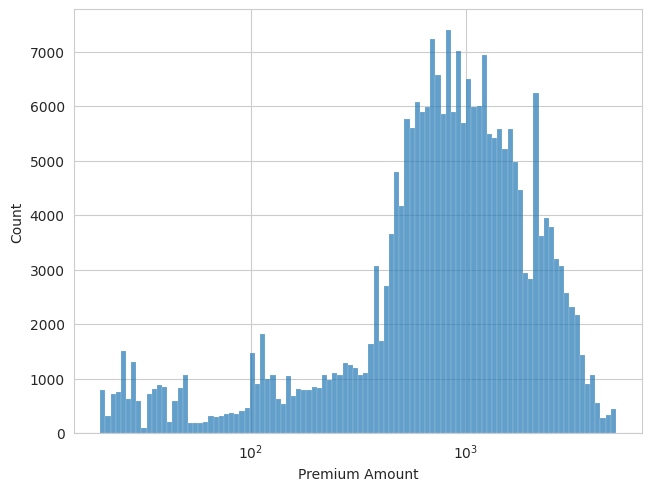

In [9]:
sns.histplot(data=df, x="Premium Amount", bins=100, alpha=0.7, lw=0.1, log_scale=True)
plt.show()

/mnt/data/Projects/insurance/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


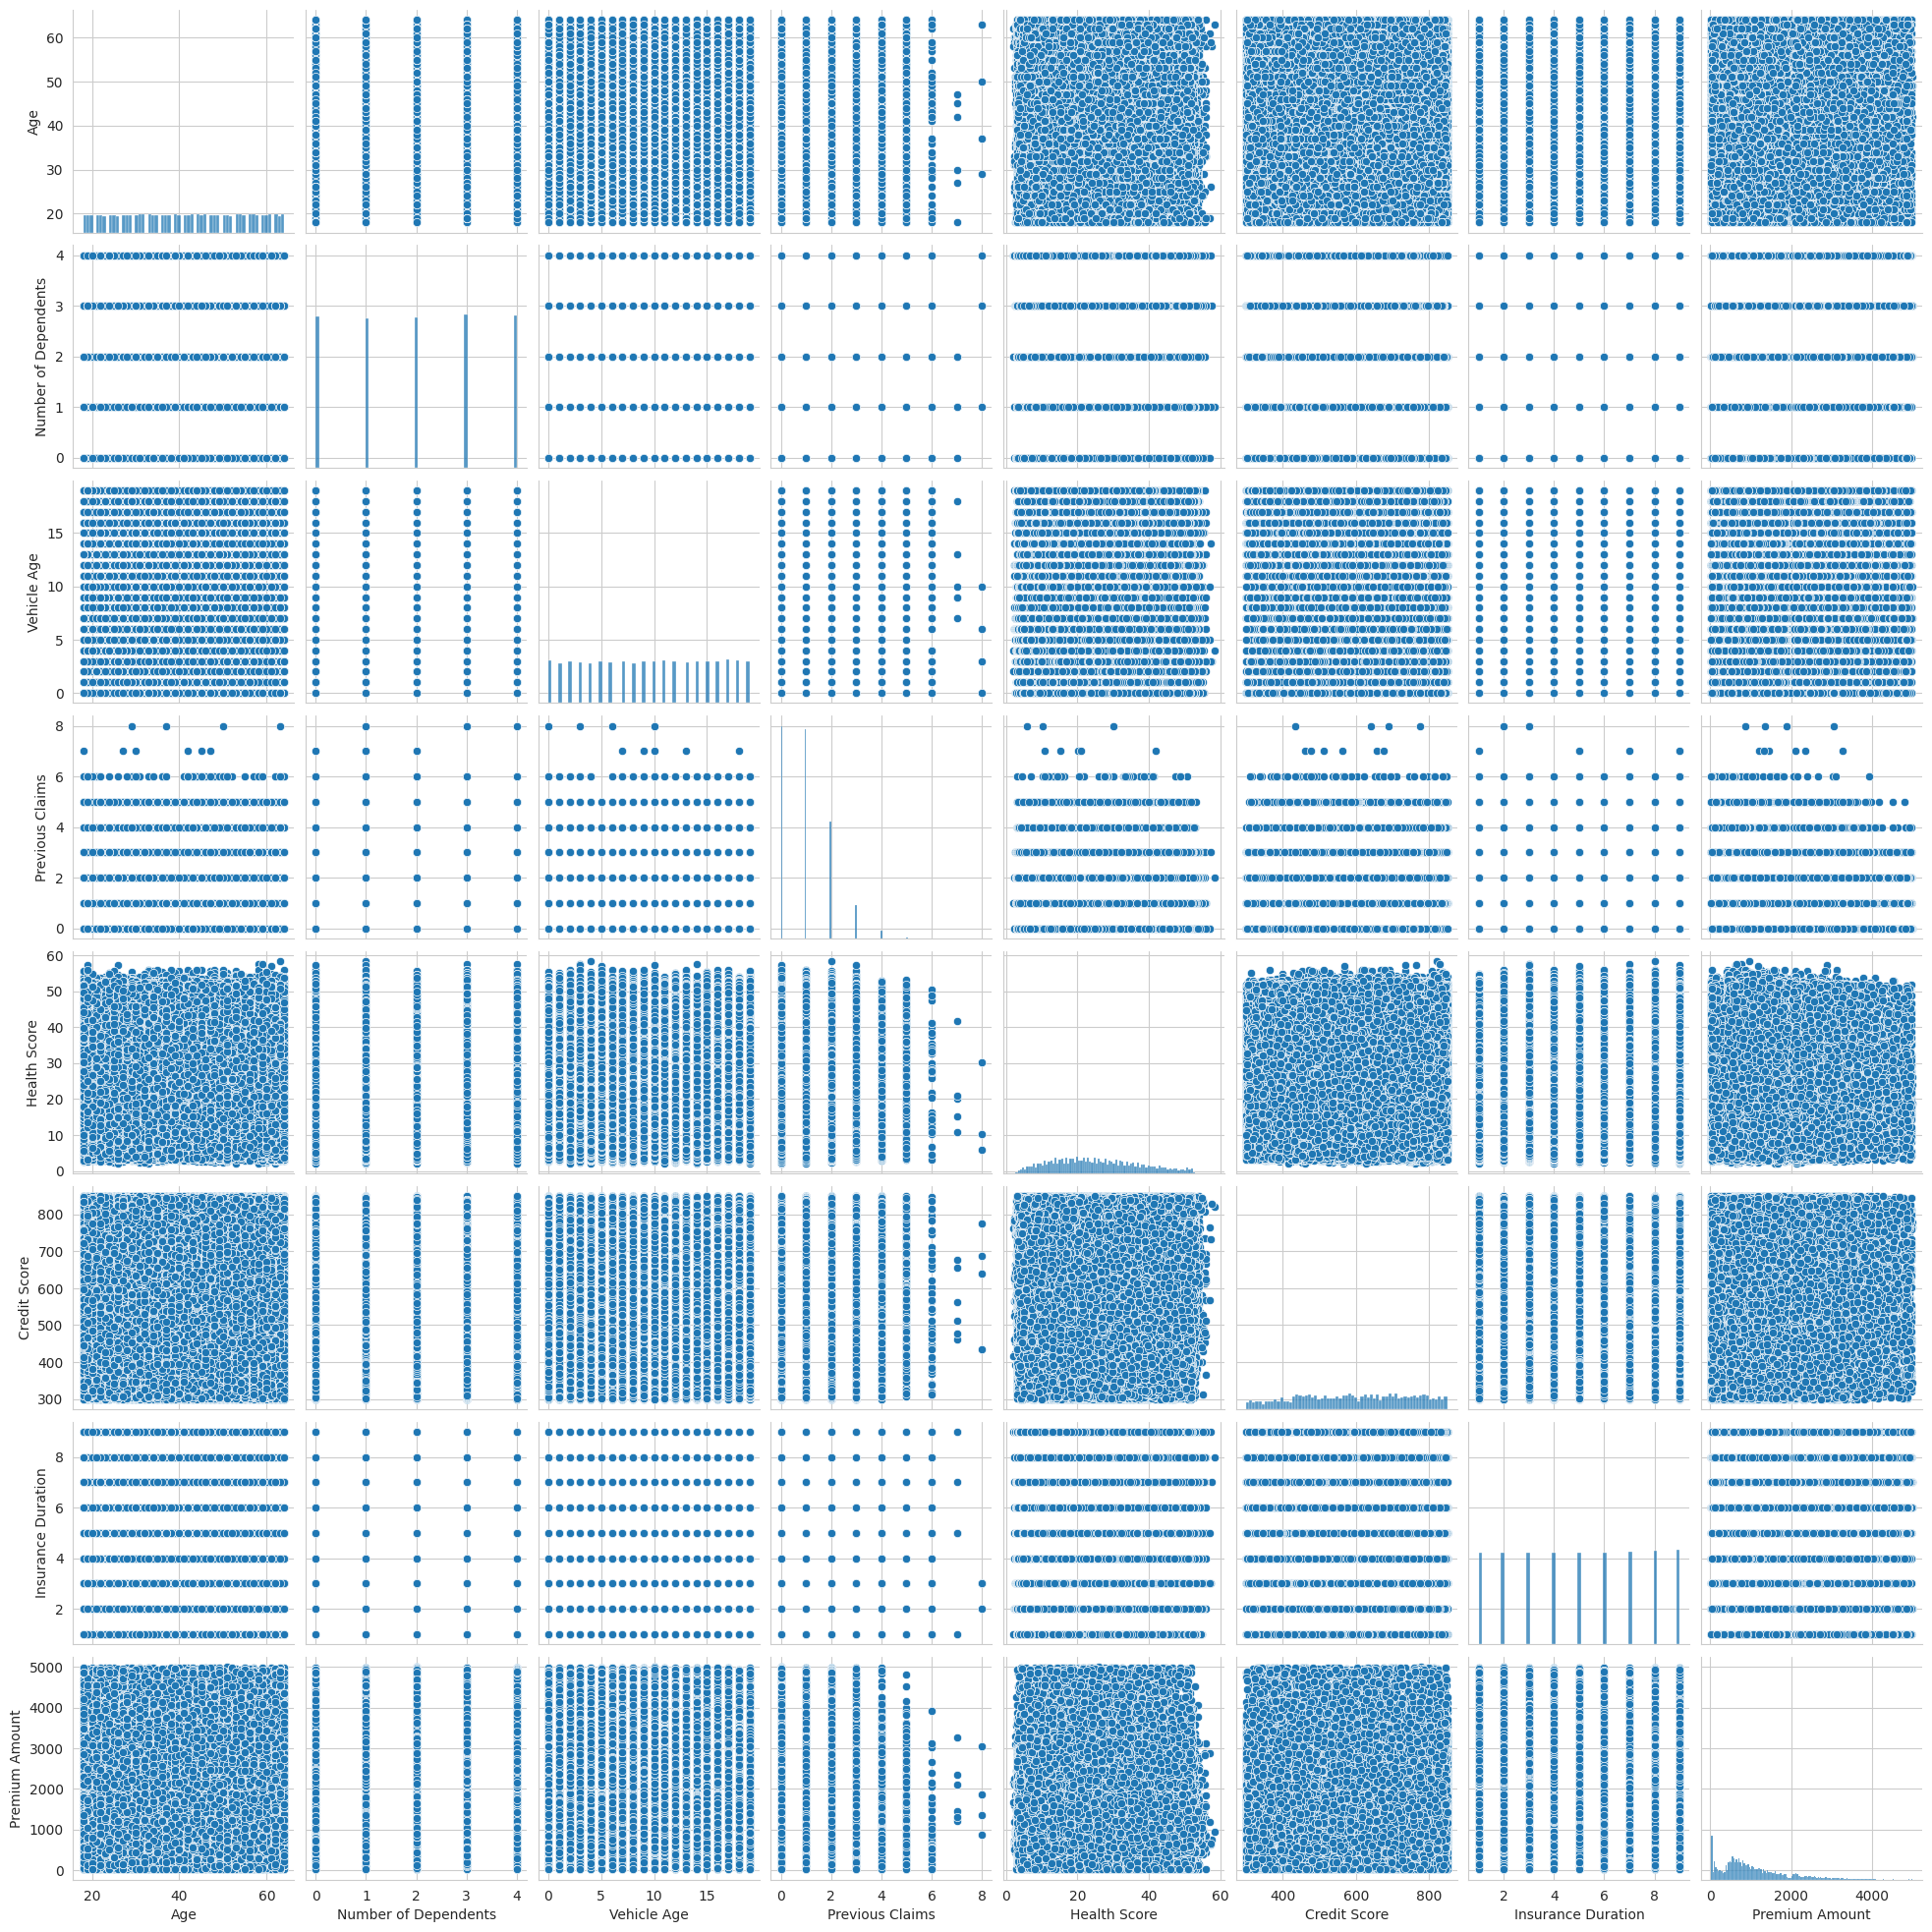

In [10]:
sns.pairplot(
    df[
        [
            "Age",
            "Number of Dependents",
            "Vehicle Age",
            "Previous Claims",
            "Health Score",
            "Credit Score",
            "Insurance Duration",
            "Premium Amount",
        ]
    ],
)

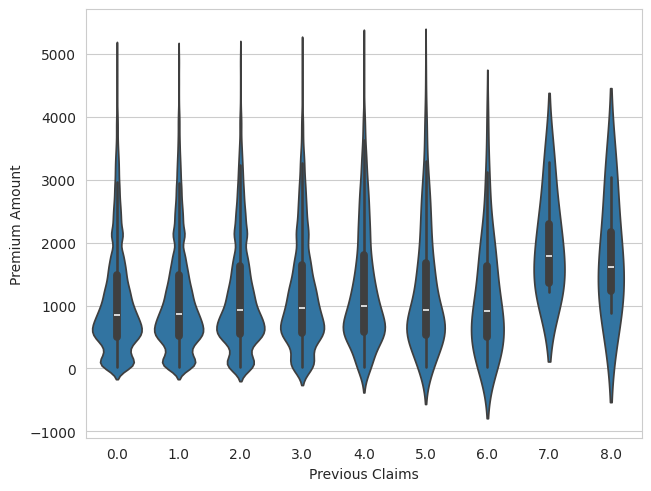

In [11]:
sns.violinplot(df, x="Previous Claims", y="Premium Amount")
plt.show()

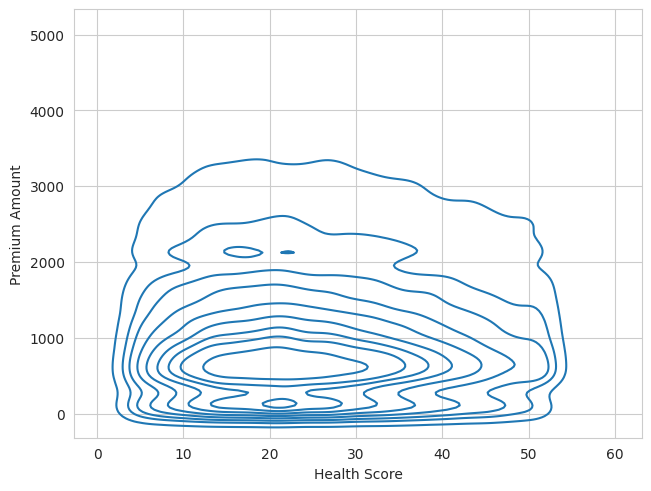

In [12]:
sns.kdeplot(df, x="Health Score", y="Premium Amount")
plt.show()